In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFECV

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Load data

In [2]:
def get_data():
    
    try:
        columns = np.load("data_columns.npy")
        X = np.load("data_valence_physio_for_svm.npy")
        Y = np.load("data_valence_label_for_svm.npy")
        return pd.DataFrame(X, columns=columns), pd.DataFrame(Y)
    except:
        print "No stored files found.. load from files first"

In [3]:
X, Y = get_data()
print X.shape
print Y.shape

(321600, 24)
(321600, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b628a8190>]],
      dtype=object)

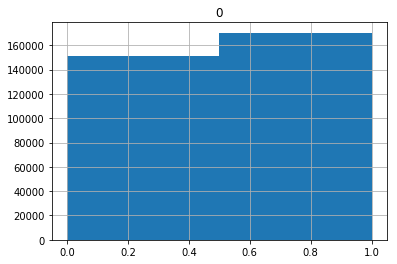

In [4]:
# binarize the problem
Y[Y<=4] = 0
Y[Y>=5] = 1
Y.hist(bins=2)

## Create train and test set

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(X, Y, test_size=.2, shuffle=False)
print xtrain.shape
print ytrain.shape
print xval.shape
print yval.shape

## LinearSVC train and test

In [6]:
lsvc = LinearSVC(C=1, tol=1e-4, dual=False, fit_intercept=True, class_weight='balanced', verbose=True)

# evaluate using 5-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(lsvc, X, Y, cv=cv, verbose=0)

print()
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Accuracy: 55.35% (0.15%)


## KBest Feature selection + SVC

In [ ]:
# Such a large set of features can cause overfitting and also slow computing
# Use feature selection to select the most important features
import sklearn.feature_selection

In [ ]:
scores_by_kbest = []

for k in range(1,24):

    kbest_selector = sklearn.feature_selection.SelectKBest(k=k)
    kbest_selector.fit(xtrain, ytrain)
    
    lsvc = LinearSVC(C=1, tol=1e-4, dual=False, fit_intercept=True, class_weight='balanced', verbose=True)
    lsvc.fit(kbest_selector.transform(xtrain), ytrain.values.ravel())
    score = lsvc.score(kbest_selector.transform(xval), yval.values.ravel())

    ks = {
        "feature" : xtrain.columns[kbest_selector.get_support()],
        "score" : score
    }
    
    scores_by_kbest.append(ks)

In [ ]:
scores = [ s["score"] for s in scores_by_kbest ]
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Validation score (nb of correct classifications)")
plt.plot(np.arange(len(scores)), scores)
plt.show()

In [ ]:
max_score = max(scores_by_kbest, key=lambda x: x["score"])
print max_score["feature"]
print max_score["score"]

## Univariate Feature Selection + SVC

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [ ]:
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(xtrain, ytrain)

In [ ]:
scores = -np.log10(selector.pvalues_)
scores[np.isinf(scores)] = scores[np.isfinite(scores)].max()
scores /= scores.max()
plt.bar(np.arange(X.shape[1]), scores, width=.2)
plt.show()

X.columns[selector.get_support()]

In [ ]:
lsvc = LinearSVC(C=1, tol=1e-4, dual=False, fit_intercept=True, class_weight='balanced', verbose=True)
lsvc.fit(selector.transform(xtrain), ytrain.values.ravel())
lsvc.score(selector.transform(xval), yval)

## Recursive feature selection

In [ ]:
lsvc = LinearSVC(C=2, tol=1e-4, dual=False, fit_intercept=True, class_weight='balanced')
rfecv = RFECV(estimator=lsvc, step=1, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
rfecv.fit(xtrain, ytrain.values.ravel())
rfecv.score(xval, yval.values.ravel())

In [ ]:
print X.columns[rfecv.get_support(indices=0)]

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()